<a href="https://colab.research.google.com/github/Lebo1024/FNBioscope_Recommender_System/blob/main/Recommender_system_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

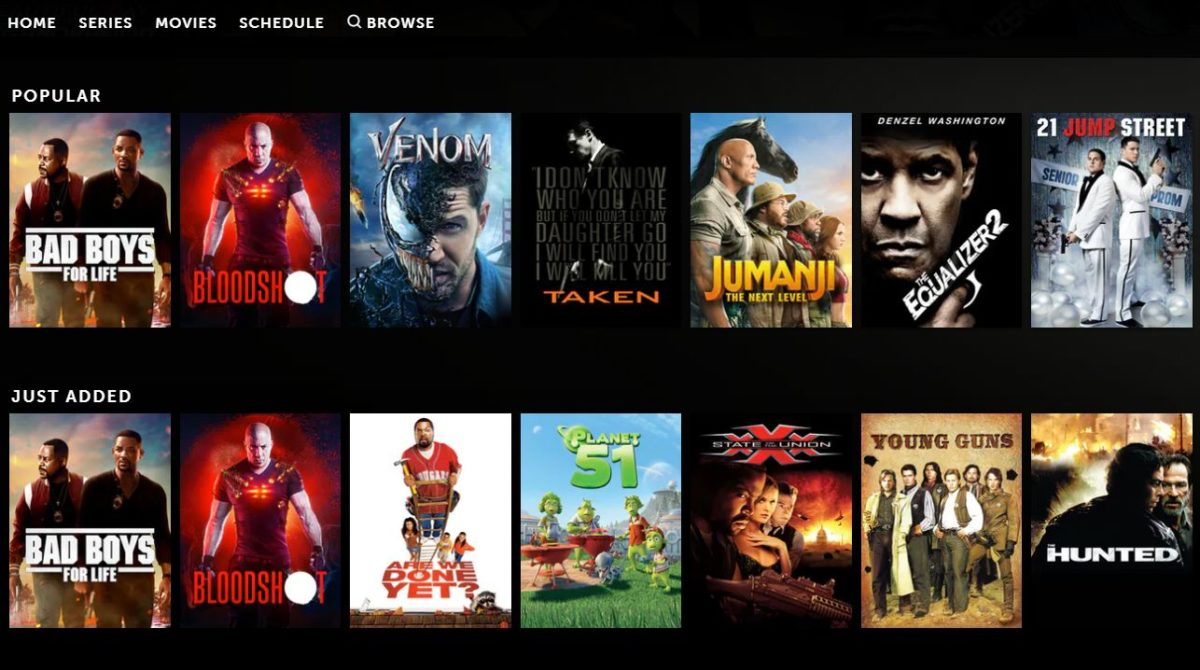

In today’s technology driven world, recommender systems are socially and economically critical for ensuring that individuals can make appropriate choices surrounding the content they engage with on a daily basis. One application where this is especially true surrounds movie content recommendations, where intelligent algorithms can help viewers find great titles from tens of thousands of options.

This notebook follows the step-by-step process to construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed based on their historical preferences.

Providing an accurate and robust solution to this challenge has immense economic potential, with users of the system being exposed to content they would like to view or purchase - generating revenue and platform affinity.

In [ ]:
#!pip install comet_ml

In [ ]:
# import comet_ml at the top of your file
#from comet_ml import Experiment

# Create an experiment with your api key
#experiment = Experiment(
#    api_key="qhh2X6dNuKmoEIokLrTCKZxat",
#    project_name="recommender-system",
#    workspace="lebo1024",
)

In [ ]:
pip install surprise

In [ ]:
#!pip install tune-sklearn ray

In [ ]:
# data analysis libraries
import pandas as pd
import numpy as np

# visualisation libraries
from matplotlib import pyplot as plt
import seaborn as sns
from numpy.random import RandomState


#word cloud
%matplotlib inline
import wordcloud

from wordcloud import WordCloud, STOPWORDS
%matplotlib inline
sns.set()

# visualisation libraries
from matplotlib import pyplot as plt
import seaborn as sns
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import plotly.express as px
import plotly.figure_factory as ff

import plotly.graph_objs as go
import plotly.offline as pyo


# ML Models
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# ML Pre processing
from surprise.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Hyperparameter tuning
from surprise.model_selection import GridSearchCV

# High performance hyperparameter tuning
from tune_sklearn import TuneSearchCV
#import warnings
#warnings.filterwarnings("ignore")

# **Data Imports**

The Expected data sets are as follows:

 

*   genome_scores.csv - a score mapping the strength between movies and tag-related properties.


*   genome_tags.csv - user assigned tags for genome-related scores
*   imdb_data.csv - Additional movie metadata scraped from IMDB using the links.csv file


*   links.csv - File providing a mapping between a MovieLens ID and associated IMDB and TMDB IDs.
*sample_submission.csv - Sample of the submission format for the hackathon.
tags.csv - User assigned for the movies within the dataset.
*test.csv - The test split of the dataset. Contains user and movie IDs with no rating data.
*train.csv - The training split of the dataset. Contains user and movie IDs with associated rating data.



.





In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/edsa-recommender-system-predict/test.csv')
movies = pd.read_csv('/content/drive/MyDrive/edsa-recommender-system-predict/movies.csv')
train = pd.read_csv("/content/drive/MyDrive/edsa-recommender-system-predict/train.csv")
imdb = pd.read_csv('/content/drive/MyDrive/edsa-recommender-system-predict/imdb_data.csv')
gtags = pd.read_csv("/content/drive/MyDrive/edsa-recommender-system-predict/genome_tags.csv")
gscores = pd.read_csv("/content/drive/MyDrive/edsa-recommender-system-predict/genome_scores.csv")
tags = pd.read_csv("/content/drive/MyDrive/edsa-recommender-system-predict/tags.csv")
links = pd.read_csv("/content/drive/MyDrive/edsa-recommender-system-predict/links.csv")

# **Basic Data Analysis**

In [ ]:
# Display top 5 rows of dataframe
train.head()

In [ ]:
#Viewing movies data
movies.head()

In [ ]:
#Viewing imdb dataframe

imdb.head()

In [ ]:
#Viewing Genrome tags
gtags.head()


In [ ]:
#Viewing scores
gscores.head()

In [ ]:
#viewing tags
tags.head()

In [ ]:
#view links
links.head()

# **Data Preprocessing**

Preparing raw data:

We will first prepare this raw data to make it suitable for our machine learning model. This is a very crucial step while for creating a machine learning model.

### **Checking for missing values column wise**

**Handling Missing Data:**

In our dataset, there may be some missing values. We cannot train our model with a dataset that contains missing values. So we have to check if our dataset has missing values.

In [ ]:
def print_dtypes_null(df):
    
    """
    This function takes a dataframe as input and prints out the
    datatypes and null values datatypes of the dataframe
    """
    
    # print data types
    print('Data type')
    print(df.info(),'\n======================')
    
    
    # get number of null values
    total = df.isnull().sum().sort_values(ascending=False)
    
    # get percentage null values
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)*100
    
    # create dataframe
    print('Missing Values')
    print(pd.concat([total, percent], axis=1, keys=['Total Number Missing', 'Percent Missing']),'\n======================')
    
    # print original dataframe for ease of reading
    print('Dataset')
    print(df.head())

# **Basic Data Analysis**

In order to facilitate the identification of missing data and data types, a function, print_dtypes_missing, is defined below

In [ ]:
print_dtypes_null(train)

In [ ]:
print_dtypes_null(test_df)

In [ ]:
print_dtypes_null(gscores)

In [ ]:
print_dtypes_null(gtags)

In [ ]:
print_dtypes_null(movies)

In [ ]:
print_dtypes_null(imdb)

imdb_data_df consists of numerical data, float64 and has no 5 columns with missing data ranging from 36% to for director to 71% budget

In [ ]:
print_dtypes_null(links)

links_df consists of numerical data, int64 and float64 and has 1 column, tmdbId with 17% missing data

In [ ]:
print_dtypes_null(tags)

tags_df consists of numerical data, int64 , and non-numeric data, object ,and has less than 1% missing values for tag column

**Conclusion:**

1.) From the assessment we see that our dataset consists of a combination of numeric and non-numeric data types.

2.) The imdb_data_df dataset is has 36% - 71% missing data across all the columns. This datatset will therefore not be considered going forward in this excercise. In a different context however, the links_df dataset would be used to source the missing data from a supplementary dataset. The links_df dataset will also not be considered going forward.

In [ ]:
#check for missing values
train.isnull().sum()

## **Checking for duplicates records**

In [ ]:
# check duplicates
dup_bool = train.duplicated(['userId', 'movieId', 'rating'])

# display duplicates
print("Number of duplicate records:", sum(dup_bool))

## **Creating a copy**

We will rename our train data as df and look at the top 5 records in the dataframe.

In [ ]:
# Create a copy
df = train.copy()

In [ ]:
# Create a copy of the train data
df_train = train.copy()

# Display top 5 records
df_train.head()

## **Evaluating Length of Unique Values**

In [ ]:
# Find the length of the unique use
len(df_train['userId'].unique()), len(df_train['movieId'].unique())


In [ ]:
# View movies
movies.head()

In [ ]:
# View unique values of movies
len(movies['movieId'].unique())

## **Joining Datasets**

In [ ]:
# Merge the ratings and movies
df_merge1 = train.merge(movies, on='movieId')
# View the first 5 rows
df_merge1.head()

In [ ]:
# Merging the dataset with that of the imbd
df_merge2 = train.merge(imdb, on="movieId")
# View first 5 rows
df_merge2.head()

In [ ]:
# Merging the merge data earlier on with the df_imbd
df_merge3 = df_merge1.merge(imdb, on="movieId" )
# View first 5 rows
df_merge3.head()

In [ ]:
# Check the null values of the data that has just been merged.
df_merge3.isnull().sum()

# **Basic Data Analysis: Conclusion**
From this topline EDA, we have found that the combined dataframe has many missing values as a result of the IMDB dataset missing data in all of its columns except movie ID.

Next we perform a more in-depth analysis using the combined dataframe and the insights we gleaned about out data and its limitations in the section above.

In [ ]:
# remove data that will not be considered
#del imdb
#del links

# **Exploratory Data Analysis: Introduction**

In [ ]:
def make_histogram(df, col):


    # Plot the histogram with default number of bins; label your axes
    _ = plt.hist(df[col])
    _ = plt.xlabel(col)
    _ = plt.xticks(rotation=90)
    _ = plt.ylabel('Frequency')
    
    plt.savefig(f'Histogram of {col}.png')

    # Show the plot
    plt.show()


def show_wordcloud(data, col):
    
    # define text from data
    text = ' '.join(data[col].values.astype(str))
    
    # generate wordclound
    wordcloud = WordCloud(max_words=50,
                          background_color='black',
                          scale=3,
                          random_state=4).generate(str(text))
    
    # plot wordcloud
    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
        
    plt.savefig(f'Word cloud of {col}.png')
    plt.imshow(wordcloud)
    plt.show()


def ecdf(data):
    
    """Compute ECDF for a one-dimensional array of measurements."""
    
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y


def plot_ecdf(df, col):
    
    """plot ECDF for a column, col, in a dataframe, df."""
    
    # Compute ECDF 
    x, y = ecdf(df[col])
    
    # Generate plot
    _ = plt.plot(x, y, marker='.', linestyle = 'none')
    
    # Label axes
    plt.ylabel('ECDF')
    plt.xlabel(f'{col}')
    
    
    plt.savefig(f'ecdf of {col}.png')
    
    # display
    plt.show()
    
    
def plot_category_distribution(data, category, value, plot_type=sns.violinplot):
    
    """
    To create a distribution plot. The standard plot type is violing plot.
    """
    
    # Create bee swarm plot with Seaborn's default settings
    _ = plot_type(x=category, y=value, data=data)

    # Label Title and axes
    _ = plt.title(f'distribution of {category} vs {value}')
    _ = plt.xlabel(category)
    _ = plt.xticks(rotation=90)
    _ = plt.ylabel(value)
    
    
    # save the plot
    plt.savefig(f'distribution of {category} vs {value}.png')

    # Show the plot
    plt.show()

In [ ]:
train.describe().T

In [ ]:
train.nunique()

In [ ]:
# remove timestamp
#train.drop('timestamp', axis=1, inplace=True)
#train.head()

There are 10 000 038 records in the train_df dataset. However there are 162 541 usersIDs with 48 213 movies that interacted with them. There are 10 unique ratings that were made and 8 795 101 different times.

It was assumed that people view different movies at different times for reasons that have little or nothing to do with movies they like. For this reason, The timestamp data will not be assessed going forward in this exercise

The rating data was be explored below

In [ ]:
# Determining number of rows for each rating value
rows_rating = train["rating"].value_counts()
rows_rating_df = pd.DataFrame({"rating": rows_rating.index, "Rows": rows_rating.values})

# Determining percentage of rows for each rating value
percentage_rating = round(train["rating"].value_counts(normalize=True) * 100, 2)
percentage_rating_df = pd.DataFrame(
    {"rating": percentage_rating.index, "Percentage": percentage_rating.values}
)

# Joining row and percentage information
ratings_distribution_df = pd.merge(
    rows_rating_df, percentage_rating_df, on="rating", how="outer"
)
ratings_distribution_df.set_index("rating", inplace=True)
ratings_distribution_df.sort_index(axis=0)

In [ ]:
make_histogram(train, 'rating')


Interestingly, we see half scores (0.5, 1.5, 2.5, 3.5 and 4.5) are less commonly used than integer score values. We don't know if this is because users prefer to rate movies with integer values or if it's because half scores were introduced after the original scoring system was already in use, leading to a decreased volume in a dataset with ratings from 1995. We quickly attempt to understand this further by investigating which years recorded half-score ratings






In [ ]:
show_wordcloud(movies, 'genres')

* The most common words under the `tag` data are 'comedy' and 'drama', followed closely by 'Romance' and 'Sci-fi'

In [ ]:
make_histogram(gscores, 'relevance')

In [ ]:
plot_ecdf(gscores, 'relevance')

In [ ]:
def clean_tags(tags):
    
    """Makes elements in list of tags lower case and unique"""
    
    # make lowercase 
    tags = [str(x).lower() for x in tags]
    
    # return unique elements
    return list(set(tags))

In [ ]:
# create list of tags for each movie
movie_tags_ser = tags.groupby('movieId')['tag'].apply(list)

# remove deplicate tags and make string
movie_tags_ser = movie_tags_ser.apply(lambda x: ' '.join(clean_tags(x)))

# merge list of tags to movies dataset
movies_df = pd.merge(movies, movie_tags_ser, how='left', on='movieId')

movies_df.head()

In [ ]:
from datetime import date

In [ ]:
# Create list of date objects
rating_date_list = [
    date.fromtimestamp(timestamp) for timestamp in list(train["timestamp"])
]

# Create year column
train["review_year"] = [date_item.year for date_item in rating_date_list]
years_with_half_scores = train[
    train["rating"].isin([0.5, 1.5, 2.5, 3.5, 4.5])
]["review_year"]
unique_years_with_half_scores = set(years_with_half_scores)
print(
    "There are {} years with half scores. \nThey are: {}.".format(
        len(unique_years_with_half_scores), sorted(list(unique_years_with_half_scores))
    )
)

We can see that before 2003, movies were not rated with half scores, which helps to explain why half scores are less popular than integer scores. Before moving on, we'll check the percentage of half scores of the total for the ratings from 2003 onwards:

In [ ]:
all_scores_after_2003 = len(train["rating"])
number_of_years_with_half_scores = len(years_with_half_scores)
print(
    "The percentage of reviews with half scores in the data from 2003 onwards is {:.2%}".format(
        number_of_years_with_half_scores / all_scores_after_2003
    )
)

We can see that, even after their introduction, half scores are still not as popular as integer scores. 

Now that we have visualized the distrubution of ratings in the dataset and have a better understanding of the ratings distribution, we examine the user data:

In [ ]:
# Find the total number of users and movies and the number of unique users 
# and movies
unique_users = train["userId"].nunique()
total_users = len(train["userId"])
unique_movies = train["movieId"].nunique()
total_movies = len(train["movieId"])

# Display these values
print(
    "Total number of unique users: \t{} \n"
    "Total number of unique movies: \t{}\n"
    "Percentage of unique users: \t{:.2%}\n"
    "Percentage of unique movies: \t{:.2%}".format(
        unique_users,
        unique_movies,
        unique_users / total_users,
        unique_movies / total_movies,
    )
)

## Exploring user data

In this section we aim to explore the data specific to the users who contributed ratings. Specifically, we would like to examine how ratings vary by the total number of contributions per user (i.e. if the number of ratings the user submits impacts the rating value).

We start this EDA by generating summary statistics for the rating values:

In [ ]:
# Generate summary statistics
summary_statistics = df_merge3[["rating"]].describe().round(2)
summary_statistics

We see that the average is 3.53, which seems sensible for movie reviews with a maximum score of 5 and a minimum score of 0.5. We now want to examine how user reviews change over time and how user reviews change with the user as they become more seasoned critics. To do this, we need to aggregate user data by user IDs to get the average ratings.

In [ ]:
aggregated_df = (
    df_merge3[["userId", "rating"]].groupby("userId").agg(["count", "mean"])
)
aggregated_df.head(5)

Next we'll examine this data by plotting it in an interactive scatter plot alongside the value for the average rating of the dataset that we calculated earlier in this EDA.

In [ ]:
# Get average
average_rating = summary_statistics.loc["mean"]["rating"]

# Create figure
fig = px.scatter(x=aggregated_df["rating"]["count"], y=aggregated_df["rating"]["mean"])

# Add a title and labels to the axes
fig.update_layout(
    title="Average Rating By User's Total Rating Submissions",
    xaxis_title="Count of individual user submissions",
    yaxis_title="Average rating",
)

# Add a line for the average
fig.add_trace(
    go.Scatter(
        x=[0, 15000],
        y=[average_rating, average_rating],
        mode="lines",
        name="Average rating",
    )
)
fig.show()

From the graph above we can see there is one outlier with close to thirteen thousand reviews. This causes the rest of the data to be squashed near the y-axis, reducing our ability to see any trends. This interactive graph allows users to zoom in to examine the trends currently not visible with the outlier. For the sake of easy reading, to work around the impact of this outlier, we will drop it from the graphing data and replot the data.

In [ ]:
# Filter out the one point with over twelve thousand ratings
removed_outliers_agg_df = aggregated_df[(aggregated_df["rating"]["count"] <= 10000)]

# Create figure
fig = px.scatter(
    x=removed_outliers_agg_df["rating"]["count"],
    y=removed_outliers_agg_df["rating"]["mean"],
)

# Add a title and labels to the axes
fig.update_layout(
    title="Average Rating By User's Total Rating Submissions",
    xaxis_title="Count of individual user submissions",
    yaxis_title="Average rating",
)

# Add a line for the average
fig.add_trace(
    go.Scatter(
        x=[0, 4000],
        y=[average_rating, average_rating],
        mode="lines",
        name="Average rating",
    )
)
fig.show()

This is interesting! From 1813 reviews onwards, only two of the reviews are above the dataset average while the rest are below the average rating. One of these two has an average of 5.0, which is suspiscious - we do not expect an average of 2184 scores to yield 5.00. This user is investigated below:

In [ ]:
# Get user ID by filtering the aggregated dataframe for the count (2184) attached 
# to the user ID
user_id = aggregated_df[aggregated_df["rating"]["count"] == 2184].index.values[0]

# Filter ratings dataframe for this user
anomaly_df = df_merge3[df_merge3["userId"] == user_id]
anomaly_df.head(5)

In the dataframe above we can see the review year and timestamp look similar for the first five columns. We will extract additional data from the timestamp, specifically month and the day of the month, to see how varied the user's contributions are.

In [ ]:
anomaly_df["month"] = anomaly_df["timestamp"].apply(
    lambda x: date.fromtimestamp(x).month
)
anomaly_df["day"] = anomaly_df["timestamp"].apply(lambda x: date.fromtimestamp(x).day)

# Print out the unique number of ratings and years
print(
    "Number of reviews: {} \n \
      Unique rating values: {} \n \
      Unique years: {} \n \
      Number of distinct movies watched: {}\n \
      Number of distinct months: {}\n \
      Number of distinct days: {}".format(
        len(anomaly_df["rating"]),
        set(anomaly_df["rating"]),
        set(anomaly_df["review_year"]),
        len(set(anomaly_df["movieId"])),
        len(set(anomaly_df["month"])),
        len(set(anomaly_df["day"])),
    )
)

From this printout, we can sensibly conclude that this data is neither realistic nor valid. It is not possible for one person to watch that many movies in one day and we can therefore conclude that this user is either a bot or someone unlikely to represent other users.

The scatter plot from earlier above leaves us with a new set of questions: do people become harsher critics as they review more movies? Or are there more bad movies than good ones, leading to a lower average score by diluting the effect the few good movies have on the user's score? From the EDA earlier in this notebook, we know the most common review score is 4.0 and the average score is 3.53, which indicates perhaps it is not the prevelance of 'bad' movies as much as a change in the reviewer's behaviour as they review more movies. We will examine this trend next.

To examine this trend, we will filter our dataframe to exclude users with less than 1000 reviews. Once this is done, we create a dictionary with an item for each user_id that points to another dictionary. This inner dictionary has the year and corresponding label for each user (e.g. user 1 started reviewing movies in 1997 therefore the dictionary will look like this: user 1: {1997: Year 1} while user 2 might look like this user 2: {2005: Year 1} because they only started reviewing movies in 2005.

In [ ]:
# Filter dataframe by users with over 1000 reviews
user_ids = list(set(aggregated_df[(aggregated_df["rating"]["count"] > 1000)].index))
filtered_df = df_merge3[df_merge3["userId"].isin(user_ids)]

# Create dictionary with user ids
users_years = {}
for user_id in user_ids:
    list_of_years = sorted(
        list(set(filtered_df[filtered_df["userId"] == user_id]["review_year"]))
    )
    users_years[user_id] = {
        year: list_of_years.index(year) + 1 for year in list_of_years
    }

# Create new column in dataframe using the dictionary
filtered_df["year_label"] = [
    users_years[int(filtered_df.iloc[row]["userId"])][
        int(filtered_df.iloc[row]["review_year"])
    ]
    for row in range(len(list(filtered_df.index)))
]

filtered_df.head(5)

We then create a summary dataframe to find the average rating as well as the total number of movies reviewed by year label (i.e. how many movies in total were reviewed in reviewers' first year of reviewing movies):

In [ ]:
year_on_year_summary = (
    filtered_df[["year_label", "rating"]].groupby("year_label").agg(["mean", "count"])
)
year_on_year_summary.head(5)

We then graph this summarised data in an attempt to answer our question posed earlier regarding changes in reviewer behaviour as they become more exerienced reviewers. 

In [ ]:
# Create figure
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Bar(
        x=year_on_year_summary.index,
        y=year_on_year_summary["rating"]["count"],
        name="Number of Reviews",
    ),
    secondary_y=False,
)
fig.add_trace(
    go.Line(
        x=year_on_year_summary.index,
        y=year_on_year_summary["rating"]["mean"],
        name="Average Rating",
    ),
    secondary_y=True,
)

# Add a line for the average
fig.add_trace(
    go.Scatter(
        x=[0, 24],
        y=[average_rating, average_rating],
        mode="lines",
        name="Average rating (entire dataset)",
    ),
    secondary_y=True,
)

# Set y-axes titles
fig.update_yaxes(title_text="Average Rating", secondary_y=True)
fig.update_yaxes(title_text="Number of Reviews", secondary_y=False)

# Add a title and an x-axis label
fig.update_layout(
    title="Average Rating By Year From First Review",
    xaxis_title="Year Since First Review",
)
fig.show()

From this chart, we can see that the average score for the frequent reviewers consistently falls below the average score for the entire dataset. We can see that even in their first year of submitting reviews, the average was lower than the dataset average. Perhaps the people who regularly review movies are more passionate about them and are therefore less tolerant of a low quality movie and/or more likely to find fault with movies than someone who rarely reviews movies. 

Next , we will move away from the user data and explore the average ratings over time for the entire dataset and then for individual movies. 

This data is noisy and does not highlight a distinct relationship between the day of the week and the average rating assigned. Instead, the year in which the rating was submitted appears to have a more important effect on the size of the average rating. To examine the influence of the year further, we would probably need to combine this data with data about the economy, mental health and the political climate - for example, the stock market crash in September 2008 may have had an impact on movie budgets and mental health, causing a drop in the average rating from 2008 to 2009. The influence of external factors is beyond the scope of this EDA and will not be discussed further.

Next we will examine the ratings by movie over time, with a specific focus on movies whose reviews have changed dramatically over time (i.e. have either 'not aged well' or become cult classics). 

# Exploring individual movie trends & rating trends over time

In this section we aim to uncover insights about how the reception of a movie changes over time. Here we will focus on how a movie's average score changes over time and whether or not this change is meaningful. As with the user ratings, we will group by year and examine both the volume and average ratings the movies received over the time since it was released. 

### Movie releases by year
Here we explore the movie releases per year. We'll start by extracting the year the movie was released from the movie title.

In [ ]:
import re

In [ ]:
def extract_year(text):
    """Extracts a year from round brackets within text"""
    year = re.findall("\((\d{4})\)", text)
    if year:
        return year[-1]
    else:
        return None

In [ ]:
# Use the extract_year function to extract the year the movie was released
df_merge3["movie_release_year"] = df_merge3["title"].apply(lambda x: extract_year(x))

# Check for null values
df_merge3[df_merge3["movie_release_year"].isnull()].info()

We can see in the above that there are only 4752 rows in the entire datset that are missing a release year. We briefly determine the number of unique movies this number represents:

In [ ]:
# Extract the number of movies without release year data
null_release_year = df_merge3[df_merge3["movie_release_year"].isnull()]

# Examine results
print(
    "There are {} movies in the dataset that do not have a release year in their title.\n"
    "These movies make up {} entries, which is {:.3%} of the total.".format(
        null_release_year["movieId"].nunique(),
        len(null_release_year["movieId"]),
        null_release_year["movieId"].nunique() / len(df_merge3["movieId"]),
    )
)

These movies make up a small percentage of the total and we can therefore drop them before continuing.

In [ ]:
# Drop rows with null values for movie_release_year
df_merge3.dropna(subset=["movie_release_year"], axis=0, inplace=True)

Next we find the number of movies released per year in the dataset:

In [ ]:
# Drop duplicate movie IDs:
movies_released_year = df_merge3[["movieId", "movie_release_year"]].drop_duplicates(
    subset=["movieId"], keep=False
)
movies_released_year = movies_released_year.groupby("movie_release_year").count()

# Create figure
fig = px.line(x=movies_released_year.index, y=movies_released_year["movieId"])
fig.update_layout(
    title="Number of Movies Released Each Year",
    xaxis_title="Release Year",
    yaxis_title="Number of Movies",
)
fig.show()

We can see that the number of movies released each year shows a general increasing trend. 

This is in line with our expectations as movie production technology has improved over the years, allowing for faster production. 

### Reviews per movie release year

Next we examine how many many reviews exist for every release year:

In [ ]:
review_count_by_release_year = (
    df_merge3[["movieId", "movie_release_year"]].groupby("movie_release_year").count()
)

# Create figure
fig = px.line(
    x=review_count_by_release_year.index, y=review_count_by_release_year["movieId"]
)
fig.update_layout(
    title="Number of Reviews For Every Release Year In The Dataset",
    xaxis_title="Release Year",
    yaxis_title="Number of Reviews",
)
fig.show()

From the figure above, we can see movies that were released in 1995 are have more reviews in the dataset than any other release year. We understand that this prevelance will possibly make our models favour older movies from this era.

We then plot these charts together to develop a better understanding of our dataset:

In [ ]:
# Create figure
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Line(
        x=review_count_by_release_year.index,
        y=review_count_by_release_year["movieId"],
        name="Number of Reviews Per Release Year",
    ),
    secondary_y=False,
)
fig.add_trace(
    go.Line(
        x=movies_released_year.index,
        y=movies_released_year["movieId"],
        name="Number of Movies Released",
    ),
    secondary_y=True,
)
# Set y-axes titles
fig.update_yaxes(title_text="Number of Reviews Per Release Year", secondary_y=False)
fig.update_yaxes(title_text="Number of Movies Released", secondary_y=True)

# Add a title and an x-axis label
fig.update_layout(
    title="Number of Movies Released Per Year vs The Number of Reviews For Each Release Year",
    xaxis_title="Year",
)
fig.show()

In the chart above we see that the number of movies released in 1995 is not much different from the number of movies released in years in the same decade, yet those movies have been reviewed more than movies released before or after this year. This might be because the internet was just taking off around this time and submitting movie reviews was a new, novel process that many people took part in initially.

### Change in movie ratings over time

Next we explore how a movie's rating changes with the movies age.

In [ ]:
df_merge3["age_of_movie_when_reviewed"] = df_merge3["review_year"] - df_merge3[
    "movie_release_year"
].astype(int)
df_merge3.head(3)

In [ ]:
# Check that all movies were above 0 years old when reviewed
df_merge3[df_merge3["age_of_movie_when_reviewed"] < 0].head(3)

From the above, we see that there are movies for which reviews are logged before they were released. We'll briefly examine the movies affected by this:

In [ ]:
movies_with_incorrect_age = df_merge3[df_merge3["age_of_movie_when_reviewed"] < 0][
    "title"
]
print(
    "There are {} movies with an age at review below zero and a review "
    "timestamp/movieId that is therefore possibly incorrect\n"
    "These entries form {:.3%} of the data.\n"
    "The first 10 examples of these movies are:\n{}".format(
        movies_with_incorrect_age.nunique(),
        len(movies_with_incorrect_age) / len(df_merge3["age_of_movie_when_reviewed"]),
        list(movies_with_incorrect_age)[:10],
    )
)

These movies form only 0.004% of the data and we therefore should exclude them before proceeding. Once this is done, we'll examine how average ratings change over a movie's lifetime.

In [ ]:
# Drop rows that have an age below zero
df_merge3.drop(
    df_merge3[df_merge3["age_of_movie_when_reviewed"] < 0].index, inplace=True
)

# Create aggregated dataframe
average_rating_by_movie_age = (
    df_merge3[["age_of_movie_when_reviewed", "rating"]]
    .groupby("age_of_movie_when_reviewed")
    .agg(["mean", "count"])
)

In [ ]:
# Create figure object
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Line(
        x=average_rating_by_movie_age.index,
        y=average_rating_by_movie_age["rating"]["mean"],
        name="Average Rating",
    ),
    secondary_y=False,
)
fig.add_trace(
    go.Line(
        x=average_rating_by_movie_age.index,
        y=average_rating_by_movie_age["rating"]["count"],
        name="Number of Movies Released",
    ),
    secondary_y=True,
)

# Set y-axes titles
fig.update_yaxes(title_text="Average Rating", secondary_y=False)
fig.update_yaxes(title_text="Number of Reviews Submitted", secondary_y=True)

# Add a title and an x-axis label
fig.update_layout(
    title="Average Rating and Number of Reviews Submitted Over Movie Lifetime",
    xaxis_title="Age of Movie",
)
fig.show()

We see the average rating become a lot more volatile as the number of reviews submitted becomes smaller, which is expected because there's less smoothing. We see the number of reviews peak when movies are between 0 and 1 years old, which is also where we see an average rating very close to the dataset average. 

We also note a dip in average rating when the movies are between 5 - 12 years old, after which the average rating increases again.

### Change in budgets over time (past 5 years)

Lastly, we examine how movie budgets have changed in the past five years. We only examine the past 5 years to work around having to adjust for inflation when comparing monetary values over larger periods. 

In [ ]:
# Exclude rows with no budget values
budget_df = df_merge3[
    (~df_merge3["budget"].isnull())
    & (df_merge3["movie_release_year"].astype(int) >= 2015)
]

# Convert budget to integer
budget_df["budget"] = [
    int(re.sub("[^0-9]", "", budget)) for budget in budget_df["budget"]
]

# Check how many years there are in the dataframe
budget_df["movie_release_year"].unique()

From the above we see that movies from 2016 onwards do not have any budget-related data. This is a serious limitation of the data and no further budget analysis can be conducted (without needing to first adjust for inflation).

We now move on to examining genre trends over time.

# Base Model Testing<a name="recommender"></a>
[Return to top](#top) <br><br>

**Please run the cell below in order for the formulas to display properly.**

**The formulas will be correctly displayed in text editors like Jupyter Notebook/Kaggle, displaying these formulas on Github may result in some issues.**

With the Surprise library, the following algorithms will be used. RMSE is used as the accuracy metric for the predictions.

### NormalPredictor
A basic algorithm that does not do much work but that is still useful for comparing accuracies. This algorithm predicts a random rating based on the distribution of the training set, which is assumed to be normal.
The prediction $\hat{r}_{ui}$ is generated from a normal distribution $\mathcal{N}(\hat{\mu},\hat{\sigma}^{2})$ where $\hat{\mu}$ and $\hat{\sigma}$ are estimated from the training data using Maximum Likelihood Estimation:
$$\hat{\mu}=\frac{1}{\mid{R_{train}}\mid}\sum_{r_{ui}\in{R_{train}}} r_{ui}$$
$$\hat{\sigma}=\sqrt{\sum_{r_{ui}\in{R_{train}}} \frac{(r_{ui}-\hat{\mu})^2}{\mid{R_{train}}\mid}}$$

### BaselineOnly
A basic algorithm that does not do much work but that is still useful for comparing accuracies. This algorithm predicts the baseline estimate for a given user and item. 
$$\hat{r}_{ui}=b_{ui}=\mu+b_u+b_i$$
If user $u$ is unknown, then the bias $b_u$ is assumed to be zero. The same applies for item $i$ with $b_i$.

### KNNBasic
This is an algorithms that is directly derived from a basic nearest neighbors approach. The KNN algorithm assumes that similar things exist in close proximity. In other words, similar things are near to each other.

The actual number of neighbors that are aggregated to compute an estimation is necessarily less than or equal to $k$. First, there might just not exist enough neighbors and second, the sets $N^{k}_{i}(u)$ and $N^{k}_{u}(i)$ only include neighbors for which the similarity measure is **positive**. It would make no sense to aggregate ratings from users (or items) that are negatively correlated. For a given prediction, the actual number of neighbors can be retrieved in the `actual_k` field of the `details` dictionary of the `prediction`.
The prediction $\hat{r}_{ui}$ is set as:
<img src="https://github.com/hesterstofberg/flipcards/blob/master/KKNbasic.png?raw=true"/>
depending on the `user_based` field of the `sim_options` parameter.


### SVD
The famous SVD algorithm, as popularized by [Simon Funk](https://sifter.org/~simon/journal/20061211.html) during the Netflix Prize.

The prediction $\hat{r}_{ui}$ is set as: $\hat{r}_{ui}=\mu+b_u+b_i+q^{T}_{i}p_u$

If user $u$ is unknown, then the bias $b_u$ and the factors $p_u$ are assumed to be zero. The same applies for item $i$ with $b_i$ and $q_i$.

To estimate all the unknown, we minimize the following regularized squared error:
$$\sum_{r_{ui}\in{R_{train}}}(r_{ui}-\hat{r}_{ui})^{2}+λ(b^{2}_{i}+b^{2}_{u}+\parallel{q_{i}}\parallel^{2}+\parallel{p_{u}}\parallel^{2})$$ 
The minimization is performed by a very straightforward stochastic gradient descent:
$$b_u\gets{b_{u}+γ(e_{ui}−λb_{u})}$$
$$b_i\gets{b_{i}+γ(e_{ui}−λb_{i})}$$
$$p_u\gets{p_{u}+γ(e_{ui}.q_i−λp_{u})}$$
$$q_i\gets{q_{i}+γ(e_{ui}.p_u−λq_{i})}$$

where $e_{ui}=r_{ui}−\hat{r}_{ui}$. These steps are performed over all the ratings of the trainset and repeated `n_epochs` times. Baselines are initialized to `0`. User and item factors are randomly initialized according to a normal distribution, which can be tuned using the `init_mean` and `init_std_dev` parameters.

You also have control over the learning rate γ and the regularization term λ. Both can be different for each kind of parameter (see below). By default, learning rates are set to `0.005` and regularization terms are set to `0.02`.


### SVDpp
The SVD++ algorithm, an extension of `SVD`, takes into account implicit ratings.
The prediction $\hat{r}_{ui}$ is set as:
$$\hat{r}_{ui}=μ+b_u+b_i+q^{T}_{i}(p_u+|I_u|^{−1/2}\sum_{j\in{I_u}}y_j)$$

Where the $y_j$ terms are a new set of item factors that capture implicit ratings. Here, an implicit rating describes the fact that a user $u$ rated an item $j$, regardless of the rating value.

If user $u$ is unknown, then the bias $b_u$ and the factors $p_u$ are assumed to be zero. The same applies for item $i$ with $b_i$, $q_i$ and $y_i$.

Just as for `SVD`, the parameters are learned using a SGD on the regularized squared error objective.

Baselines are initialized to `0`. User and item factors are randomly initialized according to a normal distribution, which can be tuned using the `init_mean` and `init_std_dev` parameters.

You have control over the learning rate γand the regularization term λ. Both can be different for each kind of parameter. By default, learning rates are set to `0.005` and regularization terms are set to `0.02`.


### Nonnegative Matrix Factorization (NMF)
NMF is a matrix factorization method where we constrain the matrices to be nonnegative. It is very similar with SVD.

Suppose we factorize a matrix $X$ into two matrices $W$ and $H$ so that $X$ $\approx$ $WH$. There is no guarantee that we can recover the original matrix, so we will approximate it as best as we can. Now, suppose that $X$ is composed of m rows $x_1$, $x_2$, ... $x_m$ , $W$ is composed of k rows $w_1$, $w_2$, ... $w_k$,  $H$ is composed of m rows $h_1$, $h_2$, ... $h_m$ . Each row in $X$ can be considered a data point. For instance, in the case of decomposing images, each row in $X$ is a single image, and each column represents some feature.

<img src="https://github.com/hesterstofberg/flipcards/blob/master/NMF.png?raw=true"/>

Basically, we can interpret $x_i$ to be a weighted sum of some components (or bases if you are more familiar with linear algebra), where each row in $H$ is a component, and each row in $W$ contains the weights of each component.

<img src="https://github.com/hesterstofberg/flipcards/blob/master/NMF1.png?raw=true"/>

In practice, we introduce various conditions on the components, so that they can be interpreted in a meaningful manner. In the case of NMF, we constrict the underlying components and weights to be non-negative. Essentially, NMF decomposes each data point into an overlay of certain components.

### SlopeOne
Slope One algorithm uses simple linear regression model.The prediction $\hat{r}_{ui}$ is set as:
$$\hat{r}_{ui}=\mu_{u}+\frac{1}{\mid{R_{i}(u)}\mid}\sum_{j\in{R_{i}(u)}}dev(i,j)$$
where $R_{i}(u)$ is the set of relevant items, i.e. the set of items $j$ rated by $u$ that also have at least one common user with $i$. $dev(i,j)$ is defined as the average difference between the ratings of $i$ and those of $j$:
$$dev(i,j)=\frac{1}{\mid{U_{ij}}\mid}\sum_{u\in{U_{ij}}}r_{ui}-r_{uj}$$

### CoClustering
Basically, users and items are assigned some clusters $C_u, C_i$, and some co-clusters $C_{ui}$. The prediction $\hat{r}_{ui}$ is set as:
$$\hat{r}_{ui}=\bar{C_{ui}}+(μ_u−\bar{C_u})+(μ_i−\bar{C_i})$$
where $\bar{C_{ui}}$ is the average rating of co-cluster $C_{ui}$, $C_u$ is the average rating of $u$’s cluster, and $\bar{C_i}$ is the average rating of $i$’s cluster. 

If the user is unknown, the prediction is $\hat{r}_{ui}=μ_i$. If the item is unknown, the prediction is $\hat{r}_{ui}=μ_u$. If both the user and the item are unknown, the prediction is $\hat{r}_{ui}=μ$.

## Cross-Validation Testing
Here we perform cross-validation testing on five algorithms: SVD, NormalPredictor, BaseLineOnly, SlopeOne and CoClustering.

In [ ]:
# Select sample size of 500 000 to test base models
model_testing_df = train.sample(n=500000)

reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(model_testing_df[["userId", "movieId", "rating"]], reader)

We then calculate the RMSEs for the five algorithms and display the scores in a dataframe.

In [ ]:
benchmark = []

# Iterate over all algorithms
for algorithm in [
    SVD(),
    #NMF(),
    #NormalPredictor(),
    BaselineOnly(),
    #SlopeOne(),
    #CoClustering(),
]:

    # Perform cross validation
    results = cross_validate(algorithm, data, cv=5)

    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(
        pd.Series([str(algorithm).split(" ")[0].split(".")[-1]], index=["Algorithm"])
    )
    benchmark.append(tmp)

In [ ]:
# Show summary dataframe
summary_results = (
    pd.DataFrame(benchmark).set_index("Algorithm").sort_values("test_rmse")
)
summary_results

With a dataset of 500 000 rows the BaselineOnly model outperforms the SVD Model. The fit time of the BaselineOnly model is much better than the SVD model. Gridsearch will be performed on these two models.
Two other models, SVDpp and KNNBasic, will also be tested but seperately as the computation time might be much longer. SVDpp will be tested on the same sample size of 500 000 rows and cv of 5 but the KNNBasic will be tested on a much smaller sample set, 100 000 rows and a cv of 3 instead of 5 as we suspect that the computation time will be much longer.

In [ ]:
benchmark_2 = []

# Iterate over all algorithms
for algorithm_2 in [SVDpp()]:

    # Perform cross validation
    results_2 = cross_validate(algorithm_2, data, cv=5)

    # Get results & append algorithm name
    tmp_2 = pd.DataFrame.from_dict(results_2).mean(axis=0)
    tmp_2 = tmp_2.append(
        pd.Series([str(algorithm_2).split(" ")[0].split(".")[-1]], index=["Algorithm"])
    )
    benchmark_2.append(tmp_2)

In [ ]:
# Show summary dataframe
summary_results_2 = (
    pd.DataFrame(benchmark_2).set_index("Algorithm").sort_values("test_rmse")
)
summary_results_2

Although the SVDpp has a lower RMSE score, the fitting time is almost triple the amount of time it takes for the SVD model and is therefore not a suitable model to continue testing.

In [ ]:
## The Kaggle kernel times-out with the KNNBasic model.
## Uncomment for use in a jupyter kernel.

# model_testing_df_3 = ratings_df.sample(n=100000)
# data_3 = Dataset.load_from_df(
#     model_testing_df_3[["userId", "movieId", "rating"]], reader
# )
# benchmark_3 = []

# # Iterate over all algorithms
# for algorithm_3 in [KNNBasic()]:

#     # Perform cross validation
#     results_3 = cross_validate(algorithm_3, data_3, cv=3)

#     # Get results & append algorithm name
#     tmp_3 = pd.DataFrame.from_dict(results_3).mean(axis=0)
#     tmp_3 = tmp_3.append(
#         pd.Series([str(algorithm_3).split(" ")[0].split(".")[-1]], index=["Algorithm"])
#     )
#     benchmark_3.append(tmp_3)

In [ ]:
# # Show summary dataframe
# summary_results_3 = (
#     pd.DataFrame(benchmark_3).set_index("Algorithm").sort_values("test_rmse")
# )
# summary_results_3

The KNNBasic model was only tested on a sample size of 100 000 rows and a cv of 3 but took longer than the SVDpp model with testing on 500 000 rows and a cv of 5. The KNNBasic model is not a suitable model to pursue for further testing due to the testing time and a high RMSE.

Next we perform split testing.

## Train-Test-Split Testing of Top 2 Models
Here we perform a train-test-split test on the BaselineOnly model and SVD model.

In [ ]:
# Use all rows in Ratings dataframe
data_4 = Dataset.load_from_df(train[["userId", "movieId", "rating"]], reader)

# Test set is made of 25% of the ratings.
trainset, testset = train_test_split(data_4, test_size=0.25)

### BaselineOnly Model
Test the BaseLineOnly model.

In [ ]:
BaselineOnly_1 = BaselineOnly()

# Train the algorithm on the train set, and predict ratings for the test set
BaselineOnly_1.fit(trainset)
pred_Baseline = BaselineOnly_1.test(testset)

# Then compute RMSE
accuracy.rmse(pred_Baseline)

### SVD Model
Test the SVD model.

In [ ]:
SVD_1 = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
SVD_1.fit(trainset)
pred_SVD_1 = SVD_1.test(testset)

# Then compute RMSE
accuracy.rmse(pred_SVD_1)

Testing the two top models, SVD and BaselineOnly model, on the whole dataset with train-test-split the SVD Model has a much lower RMSE of 0.8380 compared to the BaselineOnly RMSE of 0.8683. Gridsearch will now be performed on the SVD Model to do hyperparamenter tuning and hopefully improve the model.

## GridSearch
Next we attempt to improve our model's performance by conducting a grid search on both the SVD and BaselineOnly models.

### SVD Model

In [ ]:
## Please uncomment for running in a kernel such as jupyter

# # API key to run experiment in Comet
# experiment = Experiment(
#     api_key="h9aq14TfOuTPJxNhr12fk20kk",
#     project_name="cinematic-psychic",
#     workspace="maddy-muir",
# )

# reader = Reader(rating_scale=(0.5, 5))
# model_testing_df_3 = ratings_df.sample(n=10000)
# data_3 = Dataset.load_from_df(
#     model_testing_df_3[["userId", "movieId", "rating"]], reader
# )
# param_grid = {
#     "n_factors": [10, 20, 50, 100, 150, 200],
#     "n_epochs": [15, 20, 25, 50, 75, 100],
#     "lr_all": [0.005, 0.008, 0.001],
#     "reg_all": [0.1, 0.3, 0.5],
# }

# gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=3)
# gs.fit(data_3)
# algo = gs.best_estimator["rmse"]

# # best RMSE score
# print(gs.best_score["rmse"])

# # combination of parameters that gave the best RMSE score
# print(gs.best_params["rmse"])

# experiment.log_dataset_hash(data_3)
# experiment.log_parameters({"model_type": "SVD", "param_grid": param_grid})
# experiment.log_metrics({"RMSE": gs.best_score["rmse"]})
# experiment.end()

### Model Testing with Hyper Parameters Tuned - SVD
Here we use the first set of tuned hyperparameters to train and test our second SVD model.

In [ ]:
# RMSE test whole dataset 1st set of tuned parameters - logged in Comet_ml
SVD_2 = SVD(n_factors=20, n_epochs=25, lr_all=0.008, reg_all=0.1, random_state=27)

# Train the algorithm on the trainset, and predict ratings for the testset
SVD_2.fit(trainset)
pred_SVD_2 = SVD_2.test(testset)

# Then compute RMSE
accuracy.rmse(pred_SVD_2)

We then perform the same train and test for the third SVD model below:

In [ ]:
# RMSE test whole dataset 1st set of tuned parameters - logged in Comet_ml
SVD_3 = SVD(n_factors=50, n_epochs=50, lr_all=0.005, reg_all=0.1, random_state=27)

# Train the algorithm on the trainset, and predict ratings for the testset
SVD_3.fit(trainset)
pred_SVD_3 = SVD_3.test(testset)

# Then compute RMSE
accuracy.rmse(pred_SVD_3)

The RMSE have not improved with the application of hyper parameters found via GridSearch.

Of the three models, we can see that the default parameters gives the best RMSE.

### BaselineOnly Model
We repeat this process for the BaselineOnly model by running another GridSearchCV.

In [ ]:
## Uncomment code for running in another kernel like Jupyter

# # API key to run experiment in Comet
# from surprise import BaselineOnly

# experiment = Experiment(
#     api_key="h9aq14TfOuTPJxNhr12fk20kk",
#     project_name="cinematic-psychic",
#     workspace="maddy-muir",
# )

# param_grid = {
#     "bsl_options": {
#         "method": ["sgd"],
#         "learning_rate": [0.004, 0.006, 0.008, 0.010],  # gamma
#         "reg": [0.015, 0.020, 0.025],  # lambda 1 and 5
#     }
# }
# gs_baseline = GridSearchCV(
#     BaselineOnly,
#     param_grid,
#     measures=["rmse"],
#     cv=3,
#     return_train_measures=True,
#     n_jobs=1,
# )
# gs_baseline.fit(data_3)

# algo_baseline = gs_baseline.best_estimator["rmse"]

# # best RMSE score
# print(gs_baseline.best_score["rmse"])

# # combination of parameters that gave the best RMSE score
# print(gs_baseline.best_params["rmse"])

# experiment.log_dataset_hash(data_3)
# experiment.log_parameters({"model_type": "BaselineOnly", "param_grid": param_grid})
# experiment.log_metrics({"RMSE": gs_baseline.best_score["rmse"]})

# experiment.end()

### Model Testing with Hyper Parameters Tuned - BaselineOnly
Here we 

In [ ]:
# Testing RMSE on full data set with parameters from first gridsearch
BaselineOnly_2 = BaselineOnly(
    bsl_options={"method": "sgd", "learning_rate": 0.01, "reg": 0.025}
)

# Train the algorithm on the trainset, and predict ratings for the testset
BaselineOnly_2.fit(trainset)
pred_Baseline = BaselineOnly_2.test(testset)

# Then compute RMSE
accuracy.rmse(pred_Baseline)

The BaselineOnly model RMSE did not improve with these parameters:  bsl_options={'method': 'sgd', 'learning_rate': 0.01, 'reg': 0.025}

In [ ]:
# Testing RMSE on full data set with parameters from first gridsearch
BaselineOnly_3 = BaselineOnly(bsl_options={"method": "als", "reg_i": 8, "reg_u": 4})

# Train the algorithm on the trainset, and predict ratings for the testset
BaselineOnly_3.fit(trainset)
pred_Baseline_3 = BaselineOnly_3.test(testset)

# Then compute RMSE
accuracy.rmse(pred_Baseline_3)

There was a small improvement in the RMSE score for the BaselineOnly model with these hyper parameters: 

bsl_options={'method':'als', 'reg_i':8, 'reg_u':4}

# Data Trimming<a name="trim"></a>
[Return to top](#top) <br><br> 
<centre><img src="https://library.kissclipart.com/20180906/erw/kissclipart-film-editing-clipart-film-editing-video-editing-cl-29c98066179edee5.jpg" width="25%" /></centre>

Here we discuss additional methods used in an effort to improve model performance. We begin by experimenting with the removal of users and movies with few ratings.

### Removing data for movies < 25 ratings & users <10 ratings

Here we seek to improve our RMSE score by excluding movies with very few reviews, the logic behind this process is that by excluding movies with few reviews we protentially exclude volatility. By doing this we hope to train our models on trustworthy data representative of the population data. A similar approach will be taken by excluding users that have given less than a certain number of reviews.

First we will look at the number of ratings given by a user.

In [ ]:
# Number of ratings per user
data = ratings_df.groupby("userId")["rating"].count().clip(upper=100)

# Create trace
trace = go.Histogram(
    x=data.values, name="Ratings", xbins=dict(start=0, end=100, size=2)
)
# Create layout
layout = go.Layout(
    title="Distribution Of Number of Ratings Per User (Clipped at 100)",
    xaxis=dict(title="Ratings Per User"),
    yaxis=dict(title="Count"),
    bargap=0.2,
)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [ ]:
# Group by user ID and a count of their ratings
ratings_df.groupby("userId")["rating"].count().reset_index().sort_values(
    "rating", ascending=False
)[:10]

We then perform trimming on the dataframe by removing the movies with less than 25 ratings and users with less than 10 ratings:

In [ ]:
# Removing data for movies with less than 25 ratings
min_ratings = 25
filter_movies = ratings_df["movieId"].value_counts() > min_ratings
filter_movies = filter_movies[filter_movies].index.tolist()

# Removing data for users with less than 10 ratings
min_user_ratings = 10
filter_users = ratings_df["userId"].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

ratings_new = ratings_df[
    (ratings_df["movieId"].isin(filter_movies))
    & (ratings_df["userId"].isin(filter_users))
]
print("The original data frame shape:\t{}".format(ratings_df.shape))
print("The new data frame shape:\t{}".format(ratings_new.shape))

Now that we have successfully removed this potentially disruptive data, we will move on to testing these models below:

#### Testing Models on Trimmed Dataset - I

We start by creating a new dataframe and spliting the data into a train, test split:

In [ ]:
# Use all rows in Ratings dataframe
data_5 = Dataset.load_from_df(ratings_new[["userId", "movieId", "rating"]], reader)

# Test set is made of 25% of the ratings.
trainset, testset = train_test_split(data_5, test_size=0.25)

We then run our fourth SVD model on the trimmed data:

In [ ]:
SVD_4 = SVD(random_state=27)

# Train the algorithm on the trainset, and predict ratings for the testset
SVD_4.fit(trainset)
pred_SVD_4 = SVD_4.test(testset)

# Then compute RMSE
accuracy.rmse(pred_SVD_4)

We see the RMSE is 0.8321, which is not our best score. We continue testing this trimming method by training and testing our fourth BaselineOnly model: 

In [ ]:
BaselineOnly_4 = BaselineOnly(bsl_options={"method": "als", "reg_i": 8, "reg_u": 4})

# Train the algorithm on the trainset, and predict ratings for the testset
BaselineOnly_4.fit(trainset)
pred_Baseline_4 = BaselineOnly_4.test(testset)

# Then compute RMSE
accuracy.rmse(pred_Baseline_4)

By removing users with less than 10 ratings and movies with less than 25 ratings the RMSE for the BaselineOnly model remained the same but the SVD Model improved slightly. Next we will remove a certain user and test the RMSE for BaselineOnly and SVD again.

### Removing Data for user 75309

As previously seen in the EDA user 75309 has seen an unrealistic amount of movies within one a year time period and rated all movies a 5. Below is a summary of this user's rating information:

       Number of reviews: 2184 
       Unique rating values: {5.0} 
       Unique years: {2019} 
       Number of distinct movies watched: 2184

The data for this user will now be removed and the RMSE will be evaluated.

In [ ]:
remove_user_df = ratings_new.copy()

# Drop rows for userID 75309 from data
remove_user_df.drop(
    remove_user_df[remove_user_df["userId"] == 75309].index, inplace=True
)
remove_user_df.shape

#### Test Models on Trimmed Dataset - II
We now train and test additional models on this modified data:

In [ ]:
reader = Reader(rating_scale=(0.5, 5))

# Use all rows in Ratings dataframe
data_6 = Dataset.load_from_df(remove_user_df[["userId", "movieId", "rating"]], reader)

# Test set is made of 25% of the ratings.
trainset, testset = train_test_split(data_6, test_size=0.25)

We then run our fifth SVD model on the data excluding the potential bot:

In [ ]:
SVD_5 = SVD(random_state=27)

# Train the algorithm on the trainset, and predict ratings for the testset
SVD_5.fit(trainset)
pred_SVD_5 = SVD_5.test(testset)

# Then compute RMSE
accuracy.rmse(pred_SVD_5)

We do the same with the our fifth BaselineOnly model:

In [ ]:
BaselineOnly_5 = BaselineOnly(bsl_options={"method": "als", "reg_i": 8, "reg_u": 4})

# Train the algorithm on the trainset, and predict ratings for the testset
BaselineOnly_5.fit(trainset)
pred_Baseline_5 = BaselineOnly_5.test(testset)

# Then compute RMSE
accuracy.rmse(pred_Baseline_5)

The BaselineOnly model has an improved RMSE with the additional data trimming applied for user 75309 but this is not the case with the SVD Model.

### Removing Data for all Ratings before 2010

We know that opions and humour have changed quite a bit since 1995, the first year of ratings. Because of this we want to determine if predictions will improve if we potentially remove the 'outdated' ratings. In order to test this we will only work with the data that was rated from 2010 onwards.

In [ ]:
# Copy dataframe containg ratings and year extracted
df_2010 = combined_df.copy()

# Filter by year from 2010
df_2010 = df_2010[df_2010["review_year"] >= 2010]

We create our dataset and split our data below:

In [ ]:
reader = Reader(rating_scale=(0.5, 5))

# Use all rows in Ratings dataframe
data_7 = Dataset.load_from_df(df_2010[["userId", "movieId", "rating"]], reader)

# Test set is made of 25% of the ratings.
trainset, testset = train_test_split(data_7, test_size=0.25)

We train another SVD model on this smaller, more up to date data:

In [ ]:
SVD_6 = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
SVD_6.fit(trainset)
pred_SVD_6 = SVD_6.test(testset)

# Then compute RMSE
accuracy.rmse(pred_SVD_6)

We do the same with a BaselineOnly model:

In [ ]:
BaselineOnly_6 = BaselineOnly(bsl_options={"method": "als", "reg_i": 8, "reg_u": 4})

# Train the algorithm on the trainset, and predict ratings for the testset
BaselineOnly_6.fit(trainset)
pred_Baseline_6 = BaselineOnly_6.test(testset)

# Then compute RMSE
accuracy.rmse(pred_Baseline_6)

Both the SVD and BaselineOnly model showed an improved RMSE. The next step would be to make a submission on Kaggle with the test data predictions in order to see if it is truly a better dataset to do predictions with.

# Model Building<a name="models"></a>
[Return to top](#top) <br><br>

Here we build models to test with the test data from Kaggle. We begin this process by using the entire dataset to train our model.

## Fit Model to Whole Dataset
Knowing that models perform best when trained on a lot of data, we now switch to training our model on the entire train dataset.

In [ ]:
# Use all rows in Ratings dataframe
data = Dataset.load_from_df(ratings_df[["userId", "movieId", "rating"]], reader)

# Test set is made of 25% of the ratings.
trainset, testset = train_test_split(data_4, test_size=0.25)

# Final Model Building
SVD_model = SVD(random_state=27)
trainset = data.build_full_trainset()
SVD_model.fit(trainset)

## Pickle Model for use in Streamlit

In [ ]:
# Uncomment to pickle and download the final model
# pickle.dump(SVD_model, open("./SVD_model.pkl",'wb'))

# Collaborative & Content Based Models<a name="model"></a>
[Return to top](#top) <br><br>

<center><img src="https://data-flair.training/blogs/wp-content/uploads/sites/2/2019/07/data-science-movie-recommendation-project.jpg" width="70%" /></center>


## Collaborative Filtering - Approach 1

### Matrix Factorisation

Collaborative Filtering (CF) is the most popular approach to build Recommendation System and has been successfully employed in many applications. In CF, past user behavior are analyzed in order to establish connections between users and items to recommend an item to a user based on opinions of other users. Those customers, who had similar likings in the past, will have similar likings in the future. CF faces issues with sparsity of rating matrix and growing nature of data. These challenges are well taken care of by Matrix Factorization (MF). 

Matrix decompositions are methods that reduce a matrix into constituent parts that make it easier to calculate more complex matrix operations. Matrix decomposition methods, also called matrix factorization methods, are a foundation of linear algebra in computers, even for basic operations such as solving systems of linear equations, calculating the inverse, and calculating the determinant of a matrix.


For more information regarding this topic the following source material can be referenced:

https://www.sciencedirect.com/science/article/pii/S1877050915007462

https://machinelearningmastery.com/introduction-to-matrix-decompositions-for-machine-learning/

Instead of working with all the data provided, we will select a sample to work with as one does not need all the movies and users to get a good approximation.

We start by selecting the sample and examining the number of unique movies and users in this sample we generated:

In [ ]:
# Select a sample set of 10'000 rows to work with
sample_df = ratings_df.sample(n=10000)

# Count number of unique movies and users in sample set
num_users = sample_df.userId.unique().shape[0]
num_movies = sample_df.movieId.unique().shape[0]
print(
    "Number of users = " + str(num_users) + " | Number of movies = " + str(num_movies)
)

The current structure of the dataframe is not in an ideal form, so we pivot it to work around this:

In [ ]:
# Pivot the sample set for rating so the columns are the movie ratings per user
pivot_ratings = sample_df.pivot(
    index="userId", columns="movieId", values="rating"
).fillna(0)
pivot_ratings.head()

We then create create a ratings matrix:

In [ ]:
# Format and normalize ratings matrix
R = pivot_ratings.to_numpy()
user_ratings_mean = np.mean(R, axis=1)
ratings_demeaned = R - user_ratings_mean.reshape(-1, 1)

Sparsity and density are terms used to describe the percentage of cells in a database table that are not populated and populated, respectively. From this, we understand that the sum of the sparsity and density should equal 100%. We check the sparsity level below:

In [ ]:
# Check sparsity level
sparsity = round(1.0 - len(sample_df) / float(num_users * num_movies), 3)
print("The sparsity level of the dataset is " + str(sparsity * 100) + "%")

We then use this matric we created as input to generate predictions with the SVD function:

In [ ]:
# Use the SVD function to make predictions
U, sigma, Vt = svds(ratings_demeaned, k=50)
sigma = np.diag(sigma)
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(
    -1, 1
)
predictions = pd.DataFrame(all_user_predicted_ratings, columns=pivot_ratings.columns)
predictions.head()

We then create a function to generate a dataframe of recommended movies, which is then used for a randomly selected user to test this system.

In [ ]:
# Function to provide recommended movies
def recommend_movies(pred, userID, movies, original_ratings, num_recommendations):

    # Get and sort the user's predictions
    user_row_number = userID - 1  # User ID starts at 1, not 0
    sorted_user_predictions = pred.iloc[user_row_number].sort_values(
        ascending=False
    )  # User ID starts at 1

    # Get the user's data and merge in the movie information.
    user_data = original_ratings[original_ratings.userId == (userID)]
    user_full = user_data.merge(
        movies, how="left", left_on="movieId", right_on="movieId"
    ).sort_values(["rating"], ascending=False)

    print("User {0} has already rated {1} movies.".format(userID, user_full.shape[0]))
    print(
        "Recommending highest {0} predicted ratings movies not already rated.".format(
            num_recommendations
        )
    )

    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (
        movies[~movies["movieId"].isin(user_full["movieId"])]
        .merge(
            pd.DataFrame(sorted_user_predictions).reset_index(),
            how="left",
            left_on="movieId",
            right_on="movieId",
        )
        .rename(columns={user_row_number: "Predictions"})
        .sort_values("Predictions", ascending=False)
        .iloc[:num_recommendations, :-1]
    )

    return user_full, recommendations

We test this function below by looking at user 3 and 5:

In [ ]:
# Give predictions for user 3 for top 10 movies
already_rated, predicted = recommend_movies(predictions, 3, movies_df, ratings_df, 10)

In [ ]:
already_rated.head(10)

In [ ]:
predicted.head(10)

The recommender was quite accurate in picking up on the taste of the user. The user watched "Harry Potter and the Chambers of Secret" and gave it a rating of 5 and the system recommended "Harry Potter and the Deathly Hallows: Part I"

In [ ]:
already_rated, predicted = recommend_movies(predictions, 5, movies_df, ratings_df, 10)

In [ ]:
already_rated.head(10)

In [ ]:
predicted.head(10)

Resource: https://github.com/khanhnamle1994/movielens/blob/master/SVD_Model.ipynb

## Content & Collaborative Based - Approach II

### Memory based content filtering

In this method, we don't have a usual model that learns from data to make a prediction. Instead, we use a pre-computed matrix of similarities that can be used for predictions. We collect features from each movie by selecting the genre, release year, the most relevant tags given to each movie by several users, the director and the top cast members of each movie to form a dataframe with the metadata. We use scikit-learn's TF-IDF vectorizer to transform this metadata text to vectors of features. This can be a very large vector with more than 100 000 features! We don't need that many, and not all of them will add much value to the data. We reduce the number of features with scikit-learn's Truncated SVD and we only select the features that explain most of the data. We refer to this matrix as a latent-matrix.

Aside from the metadata we have of each movie, we have another very valuable source of information available, the user data. Later in the notebook, we will be making use of this user data to make predictions when given a user ID, the collaborative based recommender system. Finally, these two systems can be used together to recommend more accurate predictions by calculating the average score of each model, this is known as a hybrid recommender system.

We start this process by filtering the user and movie data by users that rated more than 60 movies. We are losing some information in this process, but it is necessary to create a user-item matrix for the collaborative based system later in this notebook.

In [ ]:
# Filter ratings with users that rated more than 60 times to be able to pivot 
# the table
filtered_ratings = ratings_df.groupby("userId").filter(lambda x: len(x) >= 60)

# List the movie titles after filtering
movie_list_rating = filtered_ratings.movieId.unique().tolist()

# View shape of filtered ratings
print(filtered_ratings.shape)

Next we examine the percentage prevelance of unique movies in the filtered_ratings dataframe that was created above:

In [ ]:
# Calculate percentage of movies and users in filtered dataframe
unique_movies_f = (
    len(filtered_ratings.movieId.unique()) / len(ratings_df.movieId.unique()) * 100
)
unique_users_f = (
    len(filtered_ratings.userId.unique()) / len(ratings_df.userId.unique()) * 100
)

print(
    round(unique_movies_f, 2), "% of original movie titles in the filtered dataframe."
)
print(round(unique_users_f, 2), "% of original users in the filtered dataframe.")

Now that we understand the content of this dataframe, we proceed to filter the movies dataframe to exlude items not in the movie_list_rating and process the genres column:

In [ ]:
# Filter the movies dataframe with the movie titles from the filtered list
movies_df = movies_df[movies_df.movieId.isin(movie_list_rating)]

We then process the genres column to remove the pipe symbol:

In [ ]:
# Replace | in genres with a space and make lowercase to use as metadata later
movies_df["genres"] = [item.replace("|", " ").lower() for item in movies_df["genres"]]
movies_df.head()

We continue to process this dataframe by dropping the timestamp column and mappign the movie title to its ID.

In [ ]:
# Create movie dictionary to map title to id
movie_dict = dict(zip(movies_df.title.tolist(), movies_df.movieId.tolist()))

# Drop timestamp column from filtered dataframe
filtered_ratings.drop(["timestamp"], axis=1, inplace=True)
filtered_ratings.head()

Next we add tags with a high relevance score (above 0.7)

In [ ]:
# Create combined dataframe with genres, titles and tags with relevance above 0.7
combined = pd.merge(movies_df, genome_scores_df, on="movieId", how="left").merge(
    genome_tags_df, on="tagId", how="left"
)

filter_combined = combined[combined["relevance"] > 0.7]
filter_combined.drop(["tagId", "relevance"], axis=1, inplace=True)

# Replace NaN with empty string
filter_combined.fillna("", inplace=True)
filter_combined.head()

Once this is done, we're able to create a new metadata column in the dataframe by concatenating the tag with the genres.

In [ ]:
# Create metadata column from movie tags and genres
filter_combined = pd.DataFrame(
    filter_combined.groupby("movieId")["tag"].apply(lambda x: " ".join(x))
)

movies_meta = pd.merge(movies_df, filter_combined, on="movieId", how="left").fillna("")
movies_meta["metadata"] = movies_meta["tag"] + " " + movies_meta["genres"]

movies_meta[["movieId", "title", "metadata"]].head()

We now want to construct the tf-idf matrix as mentioned above

In [ ]:
# Create latent matrix from movie metadata using TF-IDF
tfidf = TfidfVectorizer(stop_words="english")

tfidf_matrix = tfidf.fit_transform(movies_meta["metadata"])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=movies_meta.index.tolist())

print(tfidf_df.shape)

Our data is ready for feature reduction! We do this using truncated SVD to select features to use.

In [ ]:
# Select top features with Truncated SVD
svd = TruncatedSVD(n_components=200)
latent_matrix = svd.fit_transform(tfidf_df)

# Plot variance expalained to see what dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, ".-", ms=10, color="blue")
plt.xlabel("Singular value components", fontsize=12)
plt.ylabel("Cumulative percent of variance", fontsize=12)
plt.show()

# Print percentage of variance explained
print(
    "200 components explains",
    round(svd.explained_variance_ratio_.sum(), 2) * 100,
    "% of the variance",
)

Finally, we can examine the relevant features:

In [ ]:
# Number of dimensions to keep
n = 200
latent_matrix_1_df = pd.DataFrame(
    latent_matrix[:, 0:n], index=movies_meta.title.tolist()
)

# Content latent matrix shape
latent_matrix.shape

### Memory-based collaborative filtering

*Users who liked this item also liked these other items.* This is a very familiar message from recommender systems all over the internet, whether it's on an online shopping platform or Netflix. With collaborative filtering, our recommender system can recommend movies that are similar to any given movie based on user ratings. This means that we make recommendations based on movies that received a similar rating by other similar users. The dataset we are working with here contains user id's, movies id's, user ratings and a timestamp to indicate when the rating was made. For our purposes, we won't be making use of the timestamp column.

We start the process by pivoting the table having movie id's as rows, user id's as columns and the ratings that each user made for a movie as the values. There are many missing ratings by users as not all users have rated all movies. This is known as a sparse matrix. We replace these missing ratings with 0's representing missing ratings. Such a large sparse matrix can be complex and computationally expensive to work with. We make use of scikit-learn's Truncated SVD once again to reduce the number of features to a chosen value that explains a percentage of the data.
cosine
The next step is to use a similarity measure to fint the top N most similar movies to any given movie. Cosine similarity is the similarity measure that we will be using here. Mathematically, Cosine similarity measures the similarity between two vectors of an inner product space. It is measured by the cosine of the angle between two vectors and determines whether two vectors are pointing in roughly the same direction.
<br><br>Cosine similarity reference: https://www.sciencedirect.com/topics/computer-science/cosine-similarity#:~:text=Cosine%20similarity%20measures%20the%20similarity,document%20similarity%20in%20text%20analysis

We start by first exmaining the dataframe and then merging and filtering the dataframe.

In [ ]:
# View filtered ratings dataset
filtered_ratings.head()

In [ ]:
# Merge with movies table with filtered ratings table
filtered_ratings_1 = pd.merge(
    movies_df[["movieId"]], filtered_ratings, on="movieId", how="right"
)

In [ ]:
# Pivot table
filtered_ratings_2 = filtered_ratings_1.pivot(
    index="movieId", columns="userId", values="rating"
).fillna(0)

We then select the top features:

In [ ]:
# Select top features with Truncated SVD
svd = TruncatedSVD(n_components=2000)
latent_matrix_2 = svd.fit_transform(filtered_ratings_2)
latent_matrix_2_df = pd.DataFrame(latent_matrix_2, index=movies_meta.title.tolist())

Next we examine data related to the variance explained:

In [ ]:
# Plot variance expalained to see what dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, ".-", ms=10, color="blue")
plt.xlabel("Singular value components", fontsize=12)
plt.ylabel("Cumulative percent of variance", fontsize=12)
plt.show()

# Print percentage of variance explained
print(
    "2000 components explains",
    round(svd.explained_variance_ratio_.sum(), 2) * 100,
    "% of the variance",
)

### Movie predictions

In the following steps, the similarity of an input movie can be calculated by making use of both the content and collaborative latent matrices. We also added a hybrid system which is an average measure of similarity from both the content and filtering matrices. Researchers argue that the hybrid system predicts the most reasonable similar movie titles compared to predictions made from a single system.

In [ ]:
# Get latent vectors for selected movie from content and collaborative matrixes
a_1 = np.array(latent_matrix_1_df.loc["Toy Story (1995)"]).reshape(1, -1)
a_2 = np.array(latent_matrix_2_df.loc["Toy Story (1995)"]).reshape(1, -1)

# Calculate the similartity of selected movie with the other movies
score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

# Hybrid - an average measure of both content and collaborative
hybrid = (score_1 + score_2) / 2.0

# Create dataframe of similar movies
dictDf = {"content": score_1, "collaborative": score_2, "hybrid": hybrid}
similar = pd.DataFrame(dictDf, index=latent_matrix_1_df.index)

# Values can be sorted by: content, collaborative or hybrid score
# Content based sorting selected here
similar.sort_values("content", ascending=False, inplace=True)

# Display top 10 movies
similar[1:].head(11)

### Model-based collaborative filtering

Finally, we will be making use of the SVD model of the Surprise package to make movie recommendations. With this model, we make a function which takes in a user ID and recommends 10 movies based on the data we have of that user.

The Singular Value Decomposition (SVD) is a method from linear algebra and is generally used as a dimensionality reduction technique to reduce the number of features of a dataset. We applied this method earlier when we reduced the number of features in our content and collaborative matrices. In the context of the recommender system, the SVD uses the same matrix structure as the collaborative based where each row represents a user, and each column represents an item. The values are ratings that are given to items by users. 

The factorisation of this matrix is done by the singular value decomposition. It finds factors of matrices from the factorisation of a high-level (user-item-rating) matrix. The singular value decomposition is a method of decomposing a matrix into three other matrices as given below:
![alt text](https://mk0analyticsindf35n9.kinstacdn.com/wp-content/uploads/2020/03/eq1.png)
Where A is a *m x n* utility matrix, *U* is a *m x r* orthogonal left singular matrix, which represents the relationship between users and latent factors, *S* is a *r x r* diagonal matrix, which describes the strength of each latent factor and *V* is a *r x n* diagonal right singular matrix, which indicates the similarity between items and latent factors. 
<br><br>
SVD reference: https://analyticsindiamag.com/singular-value-decomposition-svd-application-recommender-system/#:~:text=In%20the%20context%20of%20the,given%20to%20items%20by%20users.

We start this process by splitting our data, fitting an SVD model to the training data and testing it.

In [ ]:
# Load data from filtered ratings
data = Dataset.load_from_df(filtered_ratings[["userId", "movieId", "rating"]], reader)

# Train SVD model on 75% of known rates
trainset, testset = train_test_split(data, test_size=0.25)

# Fit svd model
algorithm = SVD(random_state=27)
algorithm.fit(trainset)

# Make predictions on testset
predictions = algorithm.test(testset)

# Accuracy score using root mean square error
accuracy.rmse(predictions)

We then create and call a function to return the top 10 movies for any user ID and we execute this function with a randonly selected user ID.

In [ ]:
# Function to return top 10 movies with user ID input
def pred_user_rating(ui):
    if ui in filtered_ratings.userId.unique():
        ui_list = filtered_ratings[filtered_ratings.userId == ui].movieId.tolist()
        d = {k: v for k, v in movie_dict.items() if not v in ui_list}
        predictedL = []
        for i, j in d.items():
            predicted = algorithm.predict(ui, j)
            predictedL.append((i, predicted[3]))
        pdf = pd.DataFrame(predictedL, columns=["movies", "ratings"])
        pdf.sort_values("ratings", ascending=False, inplace=True)
        pdf.set_index("movies", inplace=True)
        return pdf.head(10)
    else:
        print("User Id does not exist in the list!")
        return None

In [ ]:
# Select random user for top 10 movie suggestions
user_id = 162478
pred_user_rating(user_id)

Reference: https://blog.codecentric.de/en/2019/07/recommender-system-movie-lens-dataset/

## Content based system for Streamlit

The following code shows the approach we took for creating a content based recommender system for the Streamlit app. We adapted the existing function, but the main part was creating a dataframe with the appropriate metadata to make movie recommendations. We create a metadata column with movie tags that have a relevance score of more than, genres, release year, director and first 3 cast members of the film.

In [ ]:
# List the movie titles of unique title
movie_list_rating = ratings_df.movieId.unique().tolist()
print(len(movie_list_rating))

We then filter this dataframe and then create a dataframe with appropriate metadata:

In [ ]:
# Filter the movies dataframe with the movie titles from the filtered list
streamlit_movies = movies_df[movies_df.movieId.isin(movie_list_rating)]

Here we create our streamlit_combined dataframe by merging and processing the streamlit_movies dataframe created above and merging that with the genome_scores_df dataframe.

In [ ]:
# Create a copy of ratings df and drop timesatmp column
streamlit_combined = pd.merge(
    streamlit_movies, genome_scores_df, on="movieId", how="left"
).merge(genome_tags_df, on="tagId", how="left")

# Keep the tags that have a relevance higher than 0.95
streamlit_combined = streamlit_combined[streamlit_combined["relevance"] > 0.95]

# Drop tafId and relevance columns, we are done using them
streamlit_combined.drop(["tagId", "relevance"], axis=1, inplace=True)

# Replace NaN with empty string
streamlit_combined.fillna("", inplace=True)

streamlit_combined.head(3)

We continue to process and adjust the streamlit_combined dataframe below:

In [ ]:
# Group by movie Id and create tag column listing all the tags of the movie
streamlit_combined = pd.DataFrame(
    streamlit_combined.groupby("movieId")["tag"].apply(lambda x: " ".join(x))
)

# Merge movies df with combined df containing the tags
streamlit_movies_meta = pd.merge(
    streamlit_movies, streamlit_combined, on="movieId", how="left"
).fillna("")

# Merge movies df with imdb df to get director and title_cast information
streamlit_movies_meta = pd.merge(
    streamlit_movies_meta,
    imdb_data_df[["movieId", "director", "title_cast"]],
    on="movieId",
    how="left",
).fillna("")

# Replace '(no genres listed)' with empty string
streamlit_movies_meta["genres"] = streamlit_movies_meta["genres"].replace(
    "(no genres listed)", ""
)

# Make director column lowercase for consitency with metadata column we are about 
# to create
streamlit_movies_meta["director"] = streamlit_movies_meta["director"].apply(
    lambda x: x.lower()
)

# Replace | in genres with a space and make lowercase to use as metadata later
streamlit_movies_meta["genres"] = [
    item.replace("|", " ").lower() for item in streamlit_movies_meta["genres"]
]

streamlit_movies_meta.head(3)

We then extract additional data from the raw data by creating a function to extract the year from the movie title and extract the top cast members from the title cast column in the dataframe.

In [ ]:
# Function to extract the year from the movie title
def extract_year(text):
    text = re.findall("\((\d{4})\)", text)
    for item in text:
        text = int(item)
    return text

In [ ]:
# Create new 'year' column by extracting year from title
streamlit_movies_meta["year"] = streamlit_movies_meta["title"].apply(extract_year)

# Create new top_cast column with first 3 actors of title_cast, seperated on the '|''
streamlit_movies_meta["top_cast"] = streamlit_movies_meta["title_cast"].apply(
    lambda x: " ".join(x.lower().split("|")[:3])
)

# Review dataframe
streamlit_movies_meta.head(3)

We continue to extract and engineer features here by adding information about the movie release year, director, cast members, tags and genres to a single column in the dataframe. We examine the results of this effort below: 

In [ ]:
# Create metadata column by combining the year, director, top_cast, tags and 
# genre columns
streamlit_movies_meta["metadata"] = (
    streamlit_movies_meta["year"].astype(str)
    + " "
    + streamlit_movies_meta["director"]
    + " "
    + streamlit_movies_meta["top_cast"]
    + " "
    + streamlit_movies_meta["tag"]
    + " "
    + streamlit_movies_meta["genres"]
)

# Review dataframe
streamlit_movies_meta[["movieId", "title", "metadata"]].head(3)

We then tokenize then contents of this column for later use with the if_idf vectorizer:

In [ ]:
# Creating tokens for the metadata
streamlit_movies_meta["metadata"] = streamlit_movies_meta["metadata"].apply(
    lambda x: word_tokenize(x)
)

# Review dataframe
streamlit_movies_meta[["movieId", "title", "metadata"]].head(3)

In a continued effort to prepare out metadata column for langauge processing, we lemmatize the words in this now tokenized column to transform each word to its base form.

In [ ]:
# Tranform words to their base form using lemmatization
lemmatizing = WordNetLemmatizer()

streamlit_movies_meta["metadata"] = streamlit_movies_meta["metadata"].apply(
    lambda x: " ".join([lemmatizing.lemmatize(i) for i in x])
)

# Review dataframe
streamlit_movies_meta[["movieId", "title", "metadata"]].head(3)

We continue the processing of the metadata cell by removing repeated words:

In [ ]:
# Remove duplicated words
streamlit_movies_meta["metadata"] = (
    streamlit_movies_meta["metadata"]
    .str.split()
    .apply(lambda x: " ".join(OrderedDict.fromkeys(x).keys()))
)

# Review dataframe
streamlit_movies_meta[["movieId", "title", "metadata"]].head(3)

Lastly, we create the tf-idf matrix and add that to a dataframe that is exported as a CSV.

In [ ]:
# Create latent matrix from movie metadata using TF-IDF
vectorizer = TfidfVectorizer(
    stop_words="english", ngram_range=(1, 2), max_features=1500
)

tfidf_matrix = vectorizer.fit_transform(streamlit_movies_meta["metadata"])

tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(), index=streamlit_movies_meta.movieId.tolist()
)

print(tfidf_df.shape)

In [ ]:
# View small subset of top features
vectorizer.get_feature_names()[600:610]

In [ ]:
# View tfidf_matrix dataframe
tfidf_df.head(3)

In [ ]:
# Save tfidf_df as csv file to reference in Streamlit app

# tfidf_df.to_csv('tfidf_df.csv',index=False)

## Collaborative Based System for Streamlit

Deploying the collaborative filtering model on our Streamlit presented quite challenge as the app input is three movies titles instead of a user ID or user name, which is a change from our current recommendation systems. Without having a user ID it is difficult for the model discussed earlier in the notebook to offer a list of predictions. 

We devised a solution to work around this problem. The following steps were taken in order provide movie recommendations on the collaborative system:

    1) Find the movie ID for each movie title provided
    2) Use the movie ID to find 5 user profiles (per movie) that gave these movies the highest rating 
       by referencing the Ratings Dataframe
    3) From this, we will now have a list of 15 user IDs
    4) Pair all these user IDs with all the movie IDs in the movies dataframe and use the SVD model to give these 
       combos a predicted rating.
    5) Use the output from step 4 and place it in a dataframe ordered in descending order by the predicted rating.
    6) Select the top n movies as recommendation for the app user.
    
Refrence code below for implementation. 

As an example the following 3 movies were selected for implementation and testing:

Grown Ups (2010)

Deadpool (2016)

Grand Budapest Hotel, The (2014)

We start by defining all the functions that are required to perform the 5 steps stated above:

In [ ]:
# Function to find the movie Id for each movie title:
def get_movie_id_from_title(title):
    return movies_df.loc[movies_df["title"] == title, "movieId"].iloc[0]

In [ ]:
# Function to extract user id's
def get_top_rated_users_for_movie(movie_id):
    """Map a given favourite movie to users within the
       MovieLens dataset with the same preference.

    Parameters
    ----------
    movie_id : int
        A MovieLens Movie ID.

    Returns
    -------
    list
        User IDs of users with similar high ratings for the given movie.

    """
    user_id_df = ratings_df.loc[ratings_df["movieId"] == movie_id].sort_values(
        "rating", axis=0, ascending=False
    )

    # Return the 5 users who rated this movie the highest
    return list(user_id_df["userId"])[:5]

In [ ]:
# Function to calculate predicted rating of users in list paired with each movie
def get_top_predictions_for_users(user_list):

    list_movieId = list(movies_df.movieId.unique())

    predicted_ratings_list = []

    for userID in user_list:
        for movieID in list_movieId:
            prediction_value = SVD_model.predict(userID, movieID)
            predicted_ratings_list.append(
                {
                    "userId": userID,
                    "movieId": movieID,
                    "predicted_rating": prediction_value.est,
                }
            )

    prediction_data = pd.DataFrame(predicted_ratings_list)
    prediction_data = prediction_data.sort_values("predicted_rating", ascending=False)

    return prediction_data[["movieId", "predicted_rating"]].iloc[:50]

This is the final function in this process, it will call of the functions above to effectively perform the 5 steps.

In [ ]:
def collab_model(movie_list, top_n=10):
    """Performs Collaborative filtering based upon a list of movies supplied
       by the app user.

    Parameters
    ----------
    movie_list : list (str)
        Favorite movies chosen by the app user.
    top_n : type
        Number of top recommendations to return to the user.

    Returns
    -------
    list (str)
        Titles of the top-n movie recommendations to the user.

    """
    # Finding movie ID's for input
    movie_ids = []
    user_ids = []

    for movie in movie_list:
        movie_id = get_movie_id_from_title(movie)
        user_id = get_top_rated_users_for_movie(movie_id)

        if user_id:
            user_ids = user_ids + user_id

    if len(user_ids) < 1:
        raise ValueError("Unable to find matching users")

    filtered_predictions = get_top_predictions_for_users(user_ids)

    prediction_output = pd.merge(
        filtered_predictions, movies_df, on="movieId", how="left"
    )

    return list(prediction_output["title"].iloc[:top_n])

We then generate a random list of movies:

In [ ]:
list_movies = [
    "Grown Ups (2010)",
    "Deadpool (2016)",
    "Grand Budapest Hotel, The (2014)",
]

We then test this system using a selection of the top ten recommended movies:

In [ ]:
collab_model(list_movies, top_n=10)